In [1]:
import sys
sys.path.append('../utils')
from nd_tools import (scale_img,
                      get_superpixel_means_as_features, 
                      get_superpixel_stds_as_features,
                      get_array_from_features)

from rio_tools import polygonize_array_to_shapefile
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from pprint import pprint

The goals of this notebook are to:
    
1. Introduce superpixel segmentation as a tool for feature extraction
2. How to use superpixels with SAR imagery and classification

# Inspecting Data

In [2]:
data_dir = Path('../data')
rgb_tif = data_dir/'rgb.tif'
coh_tifs = sorted(list(data_dir.glob('./*coh*.tif')))
coh_tifs

[PosixPath('../data/alos_coh_hh.tif'), PosixPath('../data/alos_coh_hv.tif')]

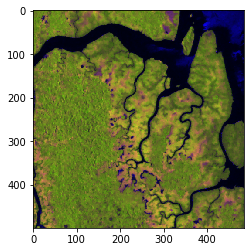

In [3]:
with rasterio.open(rgb_tif) as ds:
    rgb = ds.read().transpose([1, 2, 0])
    profile = ds.profile
plt.imshow(rgb)

# Superpixel Segmentation

The notion of the "superpixel" were first introduced in this [article](https://ttic.uchicago.edu/~xren/publication/xren_iccv03_discrim.pdf) as a way segmenting in an image into small homogeneous areas. Frequently, individual pixel analysis obscures higher level image analysis such as object detection while lowerin the resolution performs unwanted smoothing. Since superpixels were introduced, there have been numerous subsequent algorithms for extracting superpixel segmentations including the [Felzenszwalb algorithm](http://people.cs.uchicago.edu/~pff/papers/seg-ijcv.pdf) which is implemented in skimage and nicely demonstrated [here](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html). This is the algorithm we use.

For remote sensing, superpixels mitigate noise within a small homogenous image areas particularly for classifcation [1](https://ieeexplore.ieee.org/abstract/document/5593215) [2](https://ieeexplore.ieee.org/abstract/document/6247500). Additionally, they are used in global scale Mangrove extent [3](https://data.unep-wcmc.org/datasets/45) and forest loss [4](https://www.sciencedirect.com/science/article/pii/S0034425714001527).


## Using Skimage

Skimage takes a multichannel image (in this case our RGB composite) and outputs a matrix of labels so that each pixel has a unique integer label.

In [4]:
# Check the documentation and papers above for an explanation of parameters
# We don't use sigma because TV is already denoised
superpixel_labels = felzenszwalb(rgb, scale=.5, sigma=0, min_size=15, multichannel=True)
print('superpixels shape: ', superpixel_labels.shape)
print('rgb shape: ', rgb.shape)

superpixels shape:  (500, 484)
rgb shape:  (500, 484, 3)


We now visualize the array with each segment as a random color.

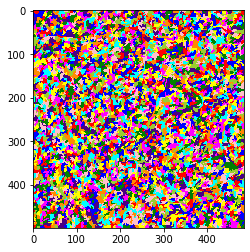

In [5]:
superpixel_labels_viz = label2rgb(superpixel_labels)
plt.imshow(superpixel_labels_viz)

# Viewing Segments in QGIS

To view in QGIS, we use the [`features`](https://rasterio.readthedocs.io/en/stable/api/rasterio.features.html) module from QGIS and [`fiona`](https://github.com/Toblerity/Fiona) to write these vectors to file. We have collected this [answer](https://gis.stackexchange.com/a/187883) from GIS stackexchange into a function.

In [6]:
polygonize_array_to_shapefile(superpixel_labels, profile, 'superpixels')

# Extracting Features from Segments

Within a segment we can extract means, variance, medians, etc. We use the [measurement](https://docs.scipy.org/doc/scipy-0.16.0/reference/ndimage.html#module-scipy.ndimage.measurements) module from scipy's ndimage. We have some functions to make their use slightly more straightforward.

In [7]:
std_features = get_superpixel_stds_as_features(superpixel_labels, rgb)
mean_features = get_superpixel_means_as_features(superpixel_labels, rgb)

/Users/cmarshak/anaconda3/envs/sari_test/lib/python3.7/site-packages/scipy/ndimage/measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts


We have features $K \times q$ where $K$ are the number of superpixels segments and $q$ are the number of channels. Skimage also ensures that are labels are of the form 0, 1, 2, ... K, so that each index of the mean feature is also its label, which makes subsequent manipulation a bit easier.

In [8]:
print('mean features shape: ', mean_features.shape)
print('Number of labels: ', len(np.unique(superpixel_labels)))

mean features shape:  (4772, 3)
Number of labels:  4772


To retiterate, ($K$ unique labels) $\times$ ($q$ channels). Here $q=3$ as we have an rgb image with three channels.

# Mean Populated Superpixels

We want to create an array corresponding to our map, where every pixel of a particular label is populated with the mean of the superpixel it belongs to. This is accomplished using `get_array_from_features`, which again is a wrapper for [`labeled_comprehension`](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.labeled_comprehension.html#scipy.ndimage.measurements.labeled_comprehension) from scipy.

In [9]:
mean_arr = get_array_from_features(superpixel_labels, mean_features)

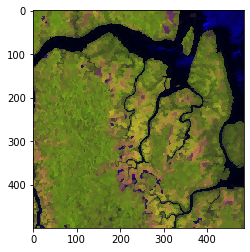

In [10]:
plt.imshow(mean_arr)

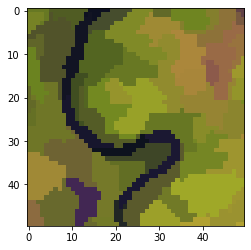

In [11]:
plt.imshow(mean_arr[200:250, 200:250])

Let's write this mean array to QGIS.

In [12]:
pprint(profile)

{'compress': 'packbits',
 'count': 3,
 'crs': CRS.from_epsg(32732),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 500,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 549563.875,
       0.0, -30.0, 10067362.0),
 'width': 484}


In [13]:
X = mean_arr.transpose([2, 0, 1])
X = X.astype(np.float32)

with rasterio.open('mean_superpixels.tif', 'w', **profile) as ds:
    # Transpose is a nice way to change from BSQ to BIP
    ds.write(X)

## Standard Deviation Populated Superpixels

Using standard deviation features, we can get a proxy for texture or how quickly the pixel values vary in a superpixel segment. Although we do not use this features for this tutorial, we mention it as a useful tool for your future analyses.

In [14]:
std_arr = get_array_from_features(superpixel_labels, std_features)
# because the variance is lower, without scaling the image can't be viewed in imshow - scales to 0-1
std_arr = scale_img(std_arr)

In [15]:
plt.imshow(std_arr)

In [16]:
plt.imshow(std_arr[200:250, 200:250])

# K-means with Superpixels

Superpixels can improve model output by grouping homogeneous areas together. We now show how to apply sklearn models to the superpixel features. We use the mean features as input.

In [17]:
model = KMeans(n_clusters=3, 
               random_state=0)
X_train = mean_features.copy()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [18]:
class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

# Populating Coherence Features

Let's use the superpixels found above to aggregate HH coherence using the mean.

In [19]:
with rasterio.open(coh_tifs[0]) as ds:
    coh_hh = ds.read(1)
coh_mean_features = get_superpixel_means_as_features(superpixel_labels, coh_hh)

In [20]:
coh_mean_arr = get_array_from_features(superpixel_labels, coh_mean_features)
plt.imshow(coh_mean_arr)

# K-means - Just coherence

Use the superpixels mean coherence to classify the image with k-means. What do you notice?

In [21]:
model = KMeans(n_clusters=3, 
               random_state=0)
X_train = coh_mean_features.copy()
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

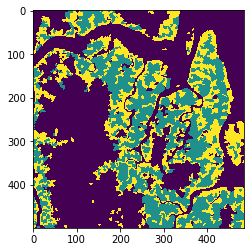

In [22]:
class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

That's a pretty good classification, but what two classes are being conflated? Ideas for separating them?


# Exercise 1

Combine coherence and backscatter means from the superpixels to obtain a classification. Hint: you can shorten up your code if you use [`np.concatentate`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html) applied to the list containing `mean_features, coh_mean_features`.

Question: do we need to scale the backscatter features to 0 and 1? Why not?

In [23]:
## Answer

model = KMeans(n_clusters=4, 
               random_state=0)
X_train = np.concatenate([mean_features, coh_mean_features], axis=1)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

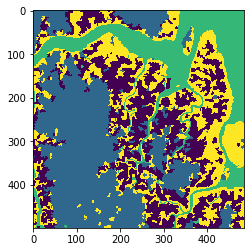

In [24]:
## Answer

class_features = model.labels_.reshape((-1, 1))
classes = get_array_from_features(superpixel_labels, class_features)
plt.imshow(classes)

In [25]:
## Answer

with rasterio.open(coh_tifs[0]) as ds:
    profile = ds.profile

profile['dtype'] = 'uint8'
profile['nodata'] = None
with rasterio.open('classes_superpixels.tif', 'w', **profile) as ds:
    ds.write(classes.astype(np.uint8), 1)

# Acknowledgements

This tutorial was written by Charlie Marshak and supervised closely by [Marc Simard](https://scholar.google.com/citations?user=JQJF1wgAAAAJ&hl=en). 

This tutorial was for the 2019 SARI training [conference](http://sari.umd.edu/meetings/international-regional-science-training) held at Prince of Songkla University, Phuket Campus. We are grateful to the conference organizers (in particular [Krishna Vadrevu](https://geog.umd.edu/facultyprofile/vadrevu/krishna)), the [SARI program](http://sari.umd.edu/), and the [LCLUC program](https://lcluc.umd.edu/) working to make this training conference possible. We are grateful for the input from and helpful conversations with [Michael Denbina](https://www.researchgate.net/profile/Michael_Denbina), [Tien-Hao Liao](https://scienceandtechnology.jpl.nasa.gov/tien-hao-liao), and Neda Kasraee. 

We gratefully and humbly acknowledge JAXA for the use of ALOS-2 data to generate a coherence image over Mondah, Gabon generated using ISCE2. We are also grateful to the ASF for providing easy access to ALOS-1 radiometrically and terrain corrected tiles over Mondah and Ko Panyi.

A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. 

Copyright 2019 by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government Sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.

This software may be subject to U.S. export control laws. By accepting this software, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required before exporting such information to foreign countries or providing access to foreign persons.
